<h1 id="Title">Topographic Differencing and Error Analysis Toolkit</h1>

<h2>Table of Contents</h2>
<ol>
    <li><a href="#introduction">Introduction</a></li>
    <li><a href="#setup">Setup</a>
        <ul>
            <li><a href="#colab">Running the notebook in Colab</a></li>
            <li><a href="#import-libraries">Import required libraries</a></li>
        </ul>
    </li>
    <li><a href="#data-access">Data access, download and pre-processing</a>
        <ul>
            <li><a href="#upload-laz">Option 1: Upload your own point cloud files</a></li>
            <li><a href="#upload-dem">Option 2: Upload your own DEMs</a></li>
            <li><a href="#download-laz">Option 3: Download point clouds using OpenTopography API</a></li>
            <li><a href="#upload-download-mix">Option 4: Upload one file and download another</a></li>
        </ul>
    </li>
    <li><a href="#visualization">Visualization and Derived Rasters</a>
        <ul>
            <li><a href="#plot-dems">Plot the DEMs</a></li>
            <li><a href="#hillshade">Hillshade</a></li>
            <li><a href="#slope">Slope</a></li>
            <li><a href="#aspect">Aspect</a></li>
            <li><a href="#roughness">Roughness</a></li>
        </ul>
    </li>
    <li><a href="#differencing">Differencing</a></li>
    <li><a href="#error-analysis">Error Analysis</a>
        <ul>
            <li><a href="#define-stable-areas">Define stable areas</a></li>
            <li><a href="#descriptive-stats">Descriptive Statistics</a></li>
            <li><a href="#estimate-error">Estimate systematic error</a></li>
        </ul>
    </li>
</ol>

<h2><a id="introduction"></a>1. Introduction</h2>

Vertical topographic differencing is a powerful technique for quantifying landscape change by comparing digital elevation models (DEMs) from different time periods. This notebook provides a comprehensive workflow for performing this analysis, with a strong emphasis on robustly quantifying the associated uncertainty. The methods implemented here are designed to identify and model various error components, including systematic bias and spatially correlated errors, which can otherwise obscure real topographic signals. The core of this workflow is a geostatistical approach that uses variogram analysis to characterize the spatial structure of error, allowing for a more nuanced and accurate assessment of topographic change than traditional methods.

The primary goal of this notebook is to provide a step-by-step guide for users to apply these methods to their own data. The analysis is broken down into several key steps:

* **Data Loading:** Importing the necessary DEMs and other data.
* **Topographic Differencing:** Calculating the difference between the DEMs.
* **Stable/Unstable Area Identification:** Delineating areas that are assumed to be unchanged between surveys to assess the survey-to-survey error.
* **Uncertainty Analysis:** Using variography to model the spatial structure of the error and generate mean uncertainty estimates.

<h2><a id="setup"></a>2. Setup</h2>

<h3><a id="colab"></a>Running the notebook in Colab</h3>

For ease-of-use, it is suggested to launch and execute these notebooks on <a href="https://colab.research.google.com/">Google Colaboratory</a> (Colab, for short), Google's Cloud Platform. Dependencies will be installed on a virtual machine on Google's cloud servers and the code will be executed directly in your browser! A major benefit of this is that you will have direct access to Google's high-end CPU/GPUs and will not have to install any dependencies locally. All deliverables will be saved to your personal Google Drive. To experiment and run one of the below Jupyter Notebooks on Google Colab click the "Open in Colab" badge below.


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Cassandra-Brigham/error_analysis/blob/main/error_analysis_notebook.ipynb)

In [ ]:
# Colab setup: install Conda once. This cell will restart the runtime.
import sys
if 'google.colab' in sys.modules:
    # Install condacolab if missing, then bootstrap conda
    try:
        import condacolab  # type: ignore
    except Exception:
        !pip -q install condacolab
        import condacolab  # type: ignore
    condacolab.install()  # <-- runtime restarts here
else:
    print("Not running in Colab; skipping Conda bootstrap.")

In [ ]:
import os, sys, subprocess, pathlib

# --- Colab guard ---
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # 1) Mount Drive (idempotent)
    from google.colab import drive
    drive.mount("/content/drive", force_remount=False)

    # 2) Repo: clone if missing, otherwise pull latest
    REPO_URL = "https://github.com/Cassandra-Brigham/error_analysis"
    REPO_DIR = "/content/error_analysis"
    if not pathlib.Path(REPO_DIR).exists():
        !git clone "$REPO_URL" "$REPO_DIR"
    else:
        !git -C "$REPO_DIR" fetch --all
        !git -C "$REPO_DIR" reset --hard origin/HEAD

    # 3) Use conda-forge for compiled geo stack (GDAL, rasterio, pyproj, shapely, geopandas, PDAL)
    #    This avoids the failing 'osgeo' pip package.
    #    Channel priority strictly from conda-forge prevents mismatched binaries.
    !mamba config --add channels conda-forge -q
    !mamba config --set channel_priority strict -q

    # Core geospatial compiled libs
    !mamba install -q -y gdal python-pdal rasterio pyproj shapely geopandas

    # 4) The rest of the pure-Python/userland packages via pip (avoid re-installing compiled deps)
    #    We explicitly skip the 'osgeo' line from requirements.txt.
    %cd "$REPO_DIR"
    !grep -v '^[[:space:]]*osgeo[[:space:]]*$' requirements.txt > /tmp/req-no-osgeo.txt
    # Prevent pip from trying to replace the conda-installed packages:
    !pip install --no-deps -r /tmp/req-no-osgeo.txt

    print("\n✅ Environment ready. You can run the rest of the notebook.")
else:
    print("Not running in Colab; skipping environment steps.")

In [ ]:
# Install visulization libraries
%pip install -q comm ipywidgets
%pip install -q ipyleaflet

from google.colab import output
output.enable_custom_widget_manager()

# Fix pyproj PROJ path
import os
os.environ["PROJ_LIB"] = "/usr/local/share/proj"
# Set OpenTopography API key
# Replace 'xxxxxxxxxxxxxxxxxxxxxxxx' with your actual OpenTopography API key.
os.environ["OPENTOPO_API_KEY"] = "xxxxxxxxxxxxxxxxxxxxxxxx"

<h3><a id="import-libraries"></a>Import required libraries</h3>

This cell imports the necessary Python libraries for data handling and analysis, including custom functions from the provided scripts for differencing, variography, and stable area analysis.

In [ ]:
import colormaps as cmaps
import os
import numpy as np
import importlib

import variography_uncertainty      

importlib.reload(variography_uncertainty)


from differencing_functions import (
    DataAccess, OpenTopographyQuery, GetDEMs, LocalDataManager, RasterPairProcessor,
    GeoidTransformer, TerrainDerivatives, TopoDifferencer, Raster, RasterPair,
)
from variography_uncertainty import (
    RasterDataHandler, StatisticalAnalysis, VariogramAnalysis, RegionalUncertaintyEstimator
)
from stable_unstable_areas import (
    TopoMapInteractor, StableAreaRasterizer, StableAreaAnalyzer
)


SEED = 42

<h2><a id="data-access"></a>Data access, download and pre-processing</h2>

This section outlines four options for loading your compare (older) and reference (newer) topographic datasets. [cite_start]The pre-processing steps ensure that both datasets are aligned to a common coordinate reference system (CRS), grid, and vertical datum, which is essential for accurate differencing[cite: 66, 109].

<h3><a id="upload-laz"></a>Option 1: Upload your own point cloud files</h3>

Use this option if you have local `.las` or `.laz` point cloud files. The code will generate Digital Terrain Models (DTMs) and Digital Surface Models (DSMs) from your data and then align them.

In [2]:
folder = 'data/upload_point_clouds/'
os.makedirs(folder, exist_ok=True)

compare_cloud_path = folder + '2016_USACE_NCMP_Topobathy.laz'
reference_cloud_path = folder + 'TX_Coastal_B2_Z15_2018.laz'
ldm_compare_dtm   = LocalDataManager(compare_cloud_path, dem_type="dtm")
ldm_compare_dsm   = LocalDataManager(compare_cloud_path, dem_type="dsm")
ldm_reference_dtm = LocalDataManager(reference_cloud_path, dem_type="dtm")
ldm_reference_dsm = LocalDataManager(reference_cloud_path, dem_type="dsm")


compare_dtm = ldm_compare_dtm.get_raster()
reference_dtm = ldm_reference_dtm.get_raster()
compare_dsm = ldm_compare_dsm.get_raster()
reference_dsm = ldm_reference_dsm.get_raster()

compare_dems = RasterPair(raster1 = compare_dtm, raster2 = compare_dsm)
reference_dems = RasterPair(raster1 = reference_dtm, raster2 = reference_dsm)
_change_dtms = RasterPair(raster1 = reference_dtm, raster2 = compare_dtm)
_change_dsms = RasterPair(raster1 = compare_dsm, raster2 = reference_dsm)

os.makedirs(folder+"processed/", exist_ok=True)

_processed_change_dtms = RasterPairProcessor(raster_pair=_change_dtms, out_dir=folder+"processed/").get_processed_pair()
_processed_change_dsms = RasterPairProcessor(raster_pair=_change_dsms, out_dir=folder+"processed/").get_processed_pair()


☁️ Processing point cloud file: 2016_USACE_NCMP_Topobathy.laz
   - Collection Dates: 2016-09-12 to 2016-09-29
   - Midpoint Epoch:   2016-09-20
✔️ Using epoch 2016-09-20 for CRS via PROJ string.
☁️ Processing point cloud file: 2016_USACE_NCMP_Topobathy.laz
   - Collection Dates: 2016-09-12 to 2016-09-29
   - Midpoint Epoch:   2016-09-20
✔️ Using epoch 2016-09-20 for CRS via PROJ string.
☁️ Processing point cloud file: TX_Coastal_B2_Z15_2018.laz
   - Collection Dates: 2018-01-18 to 2018-01-29
   - Midpoint Epoch:   2018-01-23
✔️ Using epoch 2018-01-23 for CRS via PROJ string.
☁️ Processing point cloud file: TX_Coastal_B2_Z15_2018.laz
   - Collection Dates: 2018-01-18 to 2018-01-29
   - Midpoint Epoch:   2018-01-23
✔️ Using epoch 2018-01-23 for CRS via PROJ string.
Processing raster pair: TX_Coastal_B2_Z15_2018_DTM.tif and 2016_USACE_NCMP_Topobathy_DTM.tif
   - Determined target UTM CRS: WGS 84 / UTM zone 15N (32615)
   - Reprojecting raster 1 to UTM...
   - Reprojecting raster 2 to UTM.

One of the most significant sources of long-scale error in topographic differencing comes from incorrect vertical coordinate reference system metadata, such as mismatched geoid models or a mix of ellipsoidal and orthometric heights[cite: 105, 107, 108]. The following cells check for and correct these discrepancies by transforming the datasets to a common vertical datum.

In [3]:
print("Compare point cloud original vertical CRS:", ldm_compare_dtm.orig_epsg_vt)
print("Reference point cloud original vertical CRS:", ldm_reference_dtm.orig_epsg_vt)


Compare point cloud original vertical CRS: None
Reference point cloud original vertical CRS: None


In [4]:
# If no vertical CRS is set, assign the CRS based on known metadata
vcrs_compare = 'NAVD88'
geoid_compare = 'geoid18'
vcrs_reference = 'WGS 84 ellipsoid'
geoid_reference = None

In [5]:
os.makedirs(folder+"vert_transformed/", exist_ok=True)

gt_dtms = GeoidTransformer(
        pair=_processed_change_dtms,
        compare_vcrs=vcrs_compare,
        reference_vcrs=vcrs_reference,
        compare_geoid=geoid_compare,
        reference_geoid=geoid_reference,
        out_dir="./vert_transformed",
    )

change_dtms = gt_dtms.transform()

gt_dsms = GeoidTransformer(
        pair=_processed_change_dsms,
        compare_vcrs=vcrs_compare,
        reference_vcrs=vcrs_reference,
        compare_geoid=geoid_compare,
        reference_geoid=geoid_reference,
        out_dir="./vert_transformed",
    )

change_dsms = gt_dsms.transform()


🚀 Starting vertical transformation...
   - Source HCRS: 32615
   - Source VCRS: NAVD88 (Geoid: geoid18)
   - Target VCRS: WGS 84 ellipsoid (Geoid: None)


/opt/anaconda3/envs/sage-gage-exercise/lib/python3.12/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


✔️ Transformation complete. New raster saved to: vert_transformed/TX_Coastal_B2_Z15_2018_DTM_utm_regridded_final_vtrans.tif
🚀 Starting vertical transformation...
   - Source HCRS: 32615
   - Source VCRS: NAVD88 (Geoid: geoid18)
   - Target VCRS: WGS 84 ellipsoid (Geoid: None)


/opt/anaconda3/envs/sage-gage-exercise/lib/python3.12/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


✔️ Transformation complete. New raster saved to: vert_transformed/2016_USACE_NCMP_Topobathy_DSM_utm_regridded_final_vtrans.tif


<h3><a id="upload-dem"></a>Option 2: Upload your own DEMs</h3>

If you already have DEM files (e.g., GeoTIFFs), use this option. The code will ensure they are aligned before proceeding.

In [6]:
folder = 'data/upload_dems/'
os.makedirs(folder, exist_ok=True)

compare_dtm_path = None
reference_dtm_path = None

compare_dsm_path = folder + 'Error manuscript/geometric_distortion/compare.tif' 
reference_dsm_path = folder + 'Error manuscript/geometric_distortion/reference.tif'

if compare_dtm_path:
    ldm_compare_dtm = LocalDataManager(compare_dtm_path)
    compare_dtm = ldm_compare_dtm.get_raster()
if reference_dtm_path:
    ldm_reference_dtm = LocalDataManager(reference_dtm_path)
    reference_dtm = ldm_reference_dtm.get_raster()

if compare_dsm_path:
    ldm_compare_dsm = LocalDataManager(compare_dsm_path)
    compare_dsm = ldm_compare_dsm.get_raster()
if reference_dsm_path:
    ldm_reference_dsm = LocalDataManager(reference_dsm_path)
    reference_dsm = ldm_reference_dsm.get_raster()

if compare_dtm_path and compare_dsm_path:
    compare_dems = RasterPair(raster1=compare_dtm, raster2=compare_dsm)
else:
    compare_dems = None
    
if reference_dtm_path and reference_dsm_path:
    reference_dems = RasterPair(raster1=reference_dtm, raster2=reference_dsm)
else:
    reference_dems = None

if compare_dtm_path and reference_dtm_path:
    _change_dtms = RasterPair(raster1=reference_dtm, raster2=compare_dtm)
else:
    _change_dtms = None
if compare_dsm_path and reference_dsm_path:
    _change_dsms = RasterPair(raster1=compare_dsm, raster2=reference_dsm)
else:
    _change_dsms = None

📄 Processing raster file: compare.tif
   --- Raster Metadata ---
   - Horizontal EPSG: 32612
   - Vertical EPSG:   Not Found
   - Resolution (X,Y): (1.0, -1.0)
   - Acquisition Date: Not Found
📄 Processing raster file: reference.tif
   --- Raster Metadata ---
   - Horizontal EPSG: 32612
   - Vertical EPSG:   Not Found
   - Resolution (X,Y): (1.0, -1.0)
   - Acquisition Date: Not Found


/Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Code/error_analysis/differencing_functions.py:1611: UserWarning: Could not find a valid acquisition date in the metadata for compare.tif
  warnings.warn(f"Could not find a valid acquisition date in the metadata for {raster_path.name}")
/Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Code/error_analysis/differencing_functions.py:1611: UserWarning: Could not find a valid acquisition date in the metadata for reference.tif
  warnings.warn(f"Could not find a valid acquisition date in the metadata for {raster_path.name}")


In [7]:
os.makedirs(folder+"processed/", exist_ok=True)

if compare_dtm_path and reference_dtm_path:
    processor_change_dtms = RasterPairProcessor(raster_pair=_change_dtms, out_dir=folder+"processed/")
    _processed_change_dtms = processor_change_dtms.get_processed_pair()
else:
    _processed_change_dtms = None
if compare_dsm_path and reference_dsm_path:
    processor_change_dsms = RasterPairProcessor(raster_pair=_change_dsms, out_dir=folder+"processed/")
    _processed_change_dsms = processor_change_dsms.get_processed_pair()
else:
    _processed_change_dsms = None


Processing raster pair: compare.tif and reference.tif
   - Target UTM: WGS 84 / UTM zone 12N (32612)
   - Warping reference → UTM (static)...
   - Warping compare   → UTM (dynamic if available)...
   - Calculating valid data overlap...
   - Regridding compare_32612_compare.tif to match reference_32612_reference.tif grid...
   - Cropping compare_32612_compare_regridded.tif...
   - Cropping reference_32612_reference.tif...
✅ Raster pair processing complete (UTM, epoch-aware, aligned & cropped).


As with point clouds, uploaded DEMs must be checked for vertical datum consistency.

In [16]:
# If no vertical CRS is set, assign the CRS based on known metadata
vcrs_compare = 'NAVD88'
geoid_compare = 'geoid18'
vcrs_reference = 'NAVD88'
geoid_reference = 'geoid12b'

In [ ]:
os.makedirs(folder+"vert_transformed/", exist_ok=True)

if _change_dtms:
    gt_dtms = GeoidTransformer(
            pair=_processed_change_dtms,
            compare_vcrs=vcrs_compare,
            reference_vcrs=vcrs_reference,
            compare_geoid=geoid_compare,
            reference_geoid=geoid_reference,
            out_dir=folder + "vert_transformed/",
        )

    change_dtms = gt_dtms.transform()
else:
    change_dtms = None

if _change_dsms:
    gt_dsms = GeoidTransformer(
        pair=_processed_change_dsms,
        compare_vcrs=vcrs_compare,
        reference_vcrs=vcrs_reference,
        compare_geoid=geoid_compare,
        reference_geoid=geoid_reference,
        out_dir=folder + "vert_transformed/",
    )

    change_dsms = gt_dsms.transform()
else:
    change_dsms = None

ValueError: Source orthometric requires 'compare_geoid'.

<h3><a id="download-laz"></a>Option 3: Download point clouds using OpenTopography API</h3>

This option allows you to define an area of interest (AOI), search the OpenTopography data catalog for available datasets, and download the point clouds to generate DEMs.

<h4><a id="api-key"></a>Finding and storing your API Key</h4>


We recommend storing your OT API key in a environment variable. This prevents keys from being hardcoded in the source code, reducing the risk of exposure through sharing or version control. It also enhances flexibility, allowing the same code to be used in various environments without changes. Below are the steps to take to store your API key in an environment variable.  

<h5><a id="Linux-macOS"></a>For Linux/macOS</h5>

Open up a Terminal window and find your shell's profile script. For Bash, you might find '~ /.bashrc' or '~ /.bash_profile'.
For Zsh, you might find '~ /.zshrc'.  

```cd ~```  
```ls -a```  

Once you know the name of your shell’s profile script, you can edit it using a text editor that operates in the terminal (like ```nano``` or ```vim```) or out side the terminal with the text editor of your choosing. This example will use '~/.zshrc' as the name of the shell profile script and ```nano``` as the text editor. If the file is read-only, you might need to use ```sudo``` to edit it.  

```nano ~/.zshrc```  

At the end of the .zshrc file, add a line to define your environment variable. 'your_api_key_here' is a stand in for the alphanumeric API key accessible at [MyOpenTopo](https://portal.opentopography.org/myopentopo) under "Get an API Key."   
 
```export OPENTOPOGRAPHY_API_KEY='your_api_key_here'```


Exit (```control + X``` for ```nano```) and save (```Y``` to ```Save modified buffer (ANSWERING "No" WILL DESTROY CHANGES) ?``` then ```Enter``` for ```nano```).

For your changes to take effect, you need to reload the .zshrc file or restart your terminal. To reload .zshrc without restarting, type the following command in your terminal and press Enter:  

```source ~/.zshrc```  

This will make the OPENTOPOGRAPHY_API_KEY environment variable available in all new terminal sessions.  

<h5><a id="Windows"></a>For Windows</h5> 

1. Search for "Environment Variables" in the Start menu.
1. Click on "Edit the system environment variables."
1. In the System Properties window, click on "Environment Variables."
1. Click on "New" under System variables or User variables depending on your need.
1. Set "Variable name" as OPENTOPOGRAPHY_API_KEY and "Variable value" as your actual API key. Your alphanumeric API key is accessible at [MyOpenTopo](https://portal.opentopography.org/myopentopo) under "Get an API Key."
1. Click OK and apply the changes.

<h4><a id="Load-API-Key"></a>Load API key</h4>

In [ ]:
# After setting the environment variable, access your API key in this notebook.
API_Key = os.getenv("OPENTOPO_API_KEY")

# If your API key is not set, you can set it here.
#API_Key = "your_api_key_here"

if API_Key is not None:
    print("API Key loaded successfully!")
else:
    print("Failed to load API Key.")

API Key loaded successfully!


<h4><a id="Define-AOI"></a>Define area of interest</h4>

To specify the geographic region for your dataset search, you have three options. You can 1) manually enter latitude and longitude bounds if you know the exact coordinates of your area of interest; 2) upload a shapefile or GEOJSON to automatically populate the same extent variables; 3) draw a bounding box directly on the interactive map embedded in this notebook: simply click and drag to sketch the rectangle around your target area, and the notebook captures both the corner coordinates and the equivalent WKT polygon for your API queries.

<h5><a id="Option-1-Draw-Map"></a>Option 1: Draw a bounding box on an interactive map</h5>

In [3]:
da = DataAccess()
da.init_ot_catalog_map(zoom=3)

Map(center=[39.8283, -98.5795], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

In [54]:
da.bounds

{'south': 35.123138,
 'west': -120.54491,
 'north': 35.147144,
 'east': -120.502167,
 'polygon_wkt': ['-120.54491, 35.123138, -120.54491, 35.147144, -120.502167, 35.147144, -120.502167, 35.123138, -120.54491, 35.123138']}

<h5><a id="Option-2-Manual-Bounds"></a> Option 2: Define bounds manually</h5>

In [ ]:
da = DataAccess()
south = 41.41898
north = 41.419882
west = -84.982467
east = -84.98148
da.define_bounds_manual(south, north, west, east)

<h5><a id="Option-3-Upload-File"></a> Option 3: Define bounds using an uploaded file</h5>

In [3]:
shapefile_path = "/Users/cassandrabrigham/Documents/POSTDOC/Writing/Error_manuscript/Results/Data analysis/Topographic Datasets/Short scale/Point misclassification/Boulder/GIS/bounds.shp"

da = DataAccess()

da.define_bounds_from_file(shapefile_path, target_crs = 'EPSG:4326')

{'south': 39.996841555219405,
 'west': -105.26221785885468,
 'north': 40.02280820232154,
 'east': -105.24500513344059,
 'polygon_wkt': ['-105.26211866152642, 39.996841555219405, -105.26221785885468, 40.022770728522794, -105.24509785441424, 40.02280820232154, -105.24500513344059, 39.99687899481934, -105.26211866152642, 39.996841555219405']}

<h4><a id="Use-OT-Catalog-comp-ref"></a> Use OT Catalog To Find Paired Compare/Reference Datasets</h4>

This section uses OpenTopography’s `otCatalog` API endpoint to perform a bounding‐box search of available datasets within the area of interest defined above. 

In [4]:
# Initialize the OpenTopography query object with our DataAccess instance
otq = OpenTopographyQuery(da)

otq.query_catalog(
    product_format="PointCloud",    # only return point cloud products; use "Raster" or omit to get all
    include_federated=True,         # include external catalogs (e.g. USGS 3DEP) via OpenTopography
    detail=False,                   # set to True for full metadata; False returns summary fields
    save_as="results.json"          # save raw JSON response to this file for inspection or reuse
)

# Show the first few rows of the catalog dataframe
otq.catalog_df

,Name,ID type,Data Source,Property ID,Horizontal EPSG,Vertical Coordinates,Clean Name,StartDate,EndDate
0,2010 CU-Boulder Campus and Flatirons,opentopoID,ot,OTLAS.052013.26913.1,26913,NAVD88 (GEOID 03),2010_CU_Boulder_Campus_and_Flatirons,2010-05-03,2010-05-05
1,Boulder Creek Critical Zone Observatory August...,opentopoID,ot,OTLAS.032012.26913.1,26913,NAVD88 (GEOID 03),Boulder_Creek_Critical_Zone_Observatory_August...,2010-08-21,2010-08-26
2,USGS LPC CO SoPlatteRiver Lot5 2013 LAS 2015,USGS_3DEP_ID,usgs,USGS_LPC_CO_SoPlatteRiver_Lot5_2013_LAS_2015,3857,NAVD88 - Geoid12A (Meters),USGS_LPC_CO_SoPlatteRiver_Lot5_2013_LAS_2015,2013-10-25,2014-05-31
3,CO DRCOG 1 2020,USGS_3DEP_ID,usgs,CO_DRCOG_1_2020,3857,NAVD88 height - Geoid18 (metres),CO_DRCOG_1_2020,2020-05-29,2020-08-03


<h4><a id="Select-Compare-Ref"></a> Select compare/reference datasets for differencing</h4>

In [5]:
# choose the indices of the desired reference and compare datasets 
compare_index   = 0   # Older/pre-event dataset
reference_index = 1   # Younger/post-event dataset

# now tell the query object which ones to use as which
otq.pick(compare_index, reference_index)


🔹 Compare Epoch: 2010-05-04
🔹 Reference Epoch: 2010-08-23


(Name                    2010 CU-Boulder Campus and Flatirons
 ID type                                           opentopoID
 Data Source                                               ot
 Property ID                             OTLAS.052013.26913.1
 Horizontal EPSG                                        26913
 Vertical Coordinates                       NAVD88 (GEOID 03)
 Clean Name              2010_CU_Boulder_Campus_and_Flatirons
 StartDate                                         2010-05-03
 EndDate                                           2010-05-05
 Name: 0, dtype: object,
 Name                    Boulder Creek Critical Zone Observatory August...
 ID type                                                        opentopoID
 Data Source                                                            ot
 Property ID                                          OTLAS.032012.26913.1
 Horizontal EPSG                                                     26913
 Vertical Coordinates                     

The OpenTopography API will return the geoid model (when available) used for each DEM in the metadata. 

If the vertical datum of the DEMs is not the same, we will get a warning. We need to transform one of them to match the other (here, we default to the younger/reference dataset).

We can use the metadata to transform the DEMs to a common vertical datum later.

<h4><a id="Get-DEMs"></a> Download topographic data and interpolate Digital Elevation Models </h4>

In [6]:
# Initialize the DEM interpolation/download object with our DataAccess and OpenTopographyQuery instances
gdems = GetDEMs(da, otq)

# Folder where downloaded DEMs and intermediate files will be saved

folder = "data/OT_API_download/point_classification/"
os.makedirs(folder, exist_ok=True)

# Base name for output files (DEM files will be named like "output_name" + "_compare_DTM.tif", etc.)
output_name = "boulder_point_classification"

In [7]:
gdems.dem_download_workflow(
        folder,
        output_name,
        API_Key,                           
        dem_resolution = 1.0,           
        dataset_type = "compare",
        epoch = otq.compare_epoch,           
        filterNoise = True,             
        reclassify = False,         
        savePointCloud = False,         
        pc_resolution = 0.1,            
        outCRS = "WGS84 UTM",
        method="idw",                  
        nodata=-9999,                   
        max_dist=50,                   
        smooth_iter=0                   
    )           
    

gdems.dem_download_workflow(
        folder,
        output_name,
        API_Key,
        dem_resolution = 1.0,
        dataset_type = "reference",
        epoch = otq.reference_epoch,  
        filterNoise = True,
        reclassify = False,
        savePointCloud = False,
        pc_resolution = 0.1,            
        outCRS = "WGS84 UTM",   
        method="idw",                  
        nodata=-9999,                   
        max_dist=50,                   
        smooth_iter=0                   
    ) 

/opt/anaconda3/envs/sage-gage-exercise/lib/python3.12/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


✔️ Using epoch 2010-05-04 for compare dataset via PROJ string.
✔️ Using epoch 2010-08-23 for reference dataset via PROJ string.


In [8]:
os.makedirs(folder+"processed/", exist_ok=True)

compare_dtm = Raster(folder+output_name+"_compare_DTM.tif")
compare_dsm = Raster(folder+output_name+"_compare_DSM.tif")
reference_dtm = Raster(folder+output_name+"_reference_DTM.tif")
reference_dsm = Raster(folder+output_name+"_reference_DSM.tif")

compare_dems = RasterPair(raster1 = compare_dtm, raster2 = compare_dsm)
reference_dems = RasterPair(raster1 = reference_dtm, raster2 = reference_dsm)
_change_dtms = RasterPair(raster1 = compare_dtm, raster2 = reference_dtm)
_change_dsms = RasterPair(raster1 = compare_dsm, raster2 = reference_dsm)

_processed_change_dtms = RasterPairProcessor(raster_pair=_change_dtms, out_dir=folder+"processed/").get_processed_pair()
_processed_change_dsms = RasterPairProcessor(raster_pair=_change_dsms, out_dir=folder+"processed/").get_processed_pair()

Processing raster pair: boulder_point_classification_compare_DTM.tif and boulder_point_classification_reference_DTM.tif
   - Determined target UTM CRS: WGS 84 / UTM zone 13N (32613)
   - Reprojecting raster 1 to UTM...
   - Reprojecting raster 2 to UTM...
   - Calculating valid data overlap...
   - Regridding boulder_point_classification_compare_DTM_utm.tif to match boulder_point_classification_reference_DTM_utm.tif's grid...
   - Cropping boulder_point_classification_compare_DTM_utm_regridded.tif...
   - Cropping boulder_point_classification_reference_DTM_utm.tif...
✅ Raster pair processing complete.
Processing raster pair: boulder_point_classification_compare_DSM.tif and boulder_point_classification_reference_DSM.tif
   - Determined target UTM CRS: WGS 84 / UTM zone 13N (32613)
   - Reprojecting raster 1 to UTM...
   - Reprojecting raster 2 to UTM...
   - Calculating valid data overlap...
   - Regridding boulder_point_classification_compare_DSM_utm.tif to match boulder_point_classifi

<h4><a id="Geoid"></a> Transform vertical datum of compare dataset (if necessary) </h4>

Here again, we check and transform the vertical datums to ensure consistency between the downloaded datasets.

In [9]:
print(f'Vertical CRS info - compare: {otq.catalog_df.iloc[compare_index,5]}')
print(f'Vertical CRS info - reference: {otq.catalog_df.iloc[reference_index,5]}')

Vertical CRS info - compare: NAVD88 (GEOID 03)
Vertical CRS info - reference: NAVD88 (GEOID 03)


In [10]:
vcrs_compare = 'NAVD88'
geoid_compare = 'GEOID 03'
vcrs_reference = 'NAVD88'
geoid_reference = 'GEOID 03'

In [11]:
os.makedirs(folder+"vert_transformed/", exist_ok=True)

if _change_dtms:
    gt_dtms = GeoidTransformer(
            pair=_processed_change_dtms,
            compare_vcrs=vcrs_compare,
            reference_vcrs=vcrs_reference,
            compare_geoid=geoid_compare,
            reference_geoid=geoid_reference,
            out_dir=folder + "vert_transformed/",
        )

    change_dtms = gt_dtms.transform()
else:
    change_dtms = None

if _change_dsms:
    gt_dsms = GeoidTransformer(
        pair=_processed_change_dsms,
        compare_vcrs=vcrs_compare,
        reference_vcrs=vcrs_reference,
        compare_geoid=geoid_compare,
        reference_geoid=geoid_reference,
        out_dir=folder + "vert_transformed/",
    )

    change_dsms = gt_dsms.transform()
else:
    change_dsms = None

✅ Source and target vertical systems are identical. No transformation needed.
✅ Source and target vertical systems are identical. No transformation needed.


<h3><a id="upload-download-mix"></a>Option 4: Upload one file and download another</h3>

<h2><a id="visualization"></a>Visualization and Derived Rasters</h2>

This section focuses on visualizing the results and creating derived topographic products like hillshades and slope maps, which are useful for interpreting the observed changes[cite: 206].

<h3><a id="plot-dems"></a>Plot the DEMs</h3>



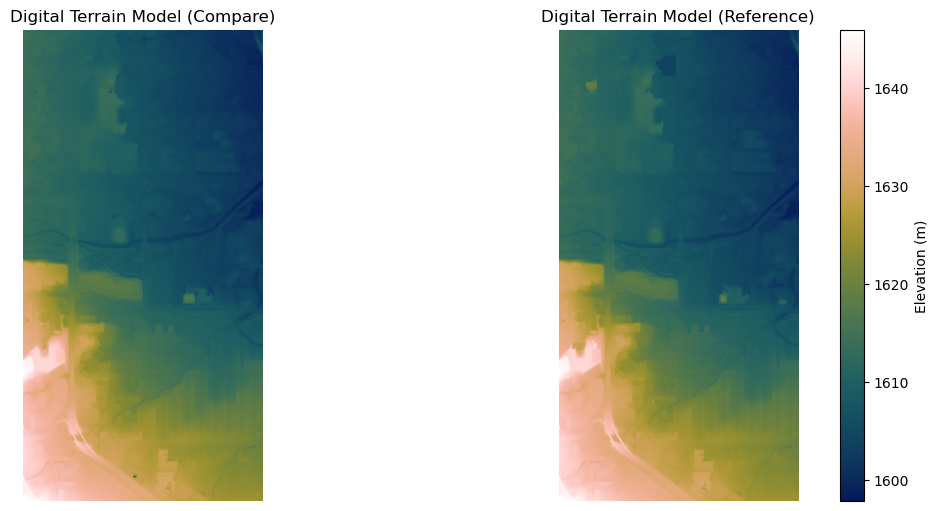

In [12]:
if change_dtms is not None:
    
    fig = change_dtms.plot_pair(
            overlay = None,
            titles=("Digital Terrain Model (Compare)", "Digital Terrain Model (Reference)"),
            base_cmap=cmaps.batloww,
            legend = "Elevation (m)",
        )

<h3><a id="hillshade"></a>Hillshade</h3>

In [12]:
out_folder_der = folder+"derivatives/"
os.makedirs(out_folder_der, exist_ok=True)


td = TerrainDerivatives(out_folder_der)

if change_dtms is not None:
    compare_hillshade_dtm = Raster(td.hillshade(compare_dtm.path, azimuth=315, altitude=45))
    reference_hillshade_dtm = Raster(td.hillshade(reference_dtm.path, azimuth=315, altitude=45))
    hillshades_dtm = RasterPair(raster1 = compare_hillshade_dtm, raster2 = reference_hillshade_dtm)

if change_dsms is not None:
    compare_hillshade_dsm = Raster(td.hillshade(compare_dsm.path, azimuth=315, altitude=45))
    reference_hillshade_dsm = Raster(td.hillshade(reference_dsm.path, azimuth=315, altitude=45))
    hillshades_dsm = RasterPair(raster1 = compare_hillshade_dsm.path, raster2 = reference_hillshade_dsm.path)

/Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Code/error_analysis/differencing_functions.py:182: UserWarning: Raster grid mismatch – reprojecting the larger raster to match the smaller.
  warnings.warn("Raster grid mismatch – reprojecting the larger raster to match the smaller.")


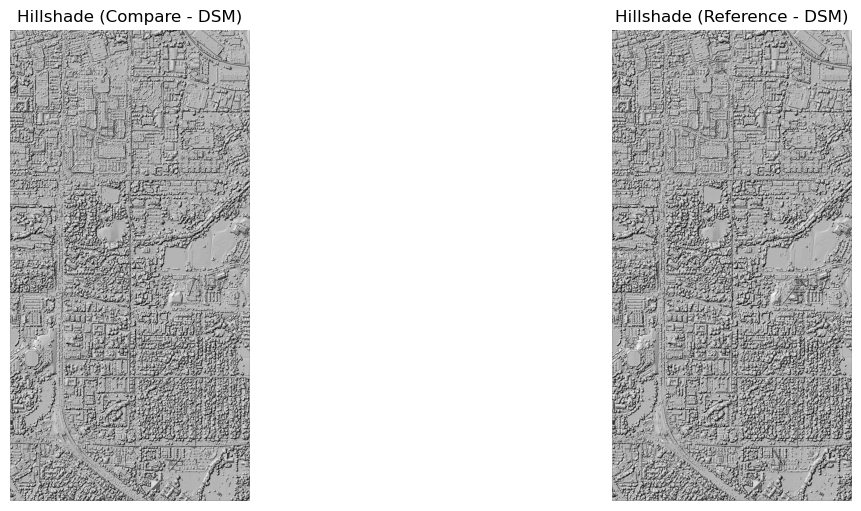

In [14]:
fig = hillshades_dsm.plot_pair(
        overlay = None,
        titles=("Hillshade (Compare - DSM)", "Hillshade (Reference - DSM)"),
        base_cmap=cmaps.gray,
    )

<h3><a id="slope"></a>Slope</h3>

In [13]:
if change_dtms is not None:
    compare_slope_dtm = Raster(td.slope(compare_dtm.path))
    reference_slope_dtm = Raster(td.slope(reference_dtm.path))
    slope_dtm = RasterPair(raster1 = compare_slope_dtm, raster2 = reference_slope_dtm)

if change_dsms is not None:
    compare_slope_dsm = Raster(td.slope(compare_dsm.path))
    reference_slope_dsm = Raster(td.slope(reference_dsm.path))
    slope_dsm = RasterPair(raster1 = compare_slope_dsm, raster2 = reference_slope_dsm)

/Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Code/error_analysis/differencing_functions.py:182: UserWarning: Raster grid mismatch – reprojecting the larger raster to match the smaller.
  warnings.warn("Raster grid mismatch – reprojecting the larger raster to match the smaller.")


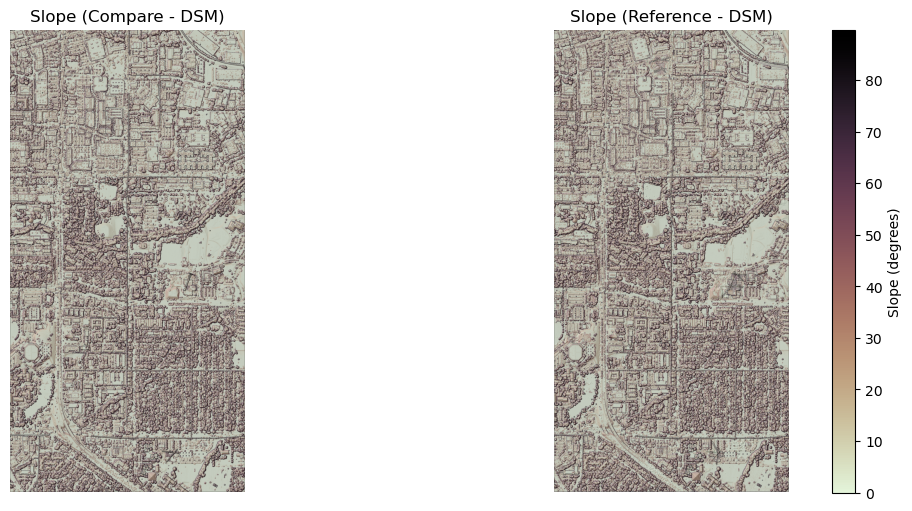

In [16]:
fig = slope_dsm.plot_pair(
        overlay = compare_hillshade_dsm,
        overlay_alpha = 0.5,
        titles=("Slope (Compare - DSM)", "Slope (Reference - DSM)"),
        base_cmap=cmaps.sepia_r,
        legend = "Slope (degrees)",
        overlay_cmap=cmaps.neutral,
          
    )

<h3><a id="aspect"></a>Aspect</h3>

In [14]:
if change_dtms is not None:
    compare_aspect_dtm = Raster(td.aspect(compare_dtm.path))
    reference_aspect_dtm = Raster(td.aspect(reference_dtm.path))
    aspect_dtm = RasterPair(raster1 = compare_aspect_dtm, raster2 = reference_aspect_dtm)

if change_dsms is not None:
    compare_aspect_dsm = Raster(td.aspect(compare_dsm.path))
    reference_aspect_dsm = Raster(td.aspect(reference_dsm.path))
    aspect_dsm = RasterPair(raster1 = compare_aspect_dsm, raster2 = reference_aspect_dsm)


/Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Code/error_analysis/differencing_functions.py:182: UserWarning: Raster grid mismatch – reprojecting the larger raster to match the smaller.
  warnings.warn("Raster grid mismatch – reprojecting the larger raster to match the smaller.")


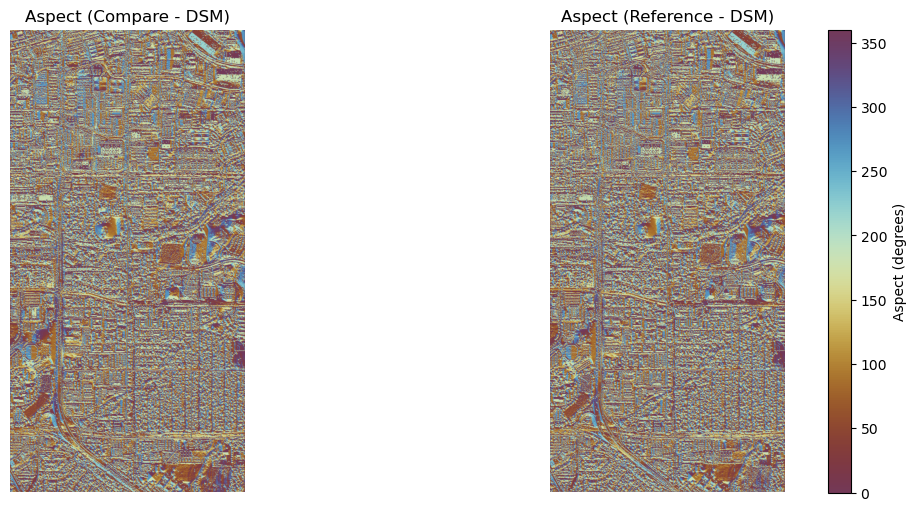

In [18]:
fig = aspect_dsm.plot_pair(
        overlay = None,
        titles=("Aspect (Compare - DSM)", "Aspect (Reference - DSM)"),
        base_cmap=cmaps.romao,
        legend = "Aspect (degrees)",
    )

<h3><a id="roughness"></a>Roughness</h3>

In [15]:
if change_dtms is not None:
    compare_roughness_dtm = Raster(td.roughness(compare_dtm.path))
    reference_roughness_dtm = Raster(td.roughness(reference_dtm.path))
    roughness_dtm = RasterPair(raster1 = compare_roughness_dtm, raster2 = reference_roughness_dtm)

if change_dsms is not None:
    compare_roughness_dsm = Raster(td.roughness(compare_dsm.path))
    reference_roughness_dsm = Raster(td.roughness(reference_dsm.path))
    roughness_dsm = RasterPair(raster1 = compare_roughness_dsm, raster2 = reference_roughness_dsm)

/Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Code/error_analysis/differencing_functions.py:182: UserWarning: Raster grid mismatch – reprojecting the larger raster to match the smaller.
  warnings.warn("Raster grid mismatch – reprojecting the larger raster to match the smaller.")


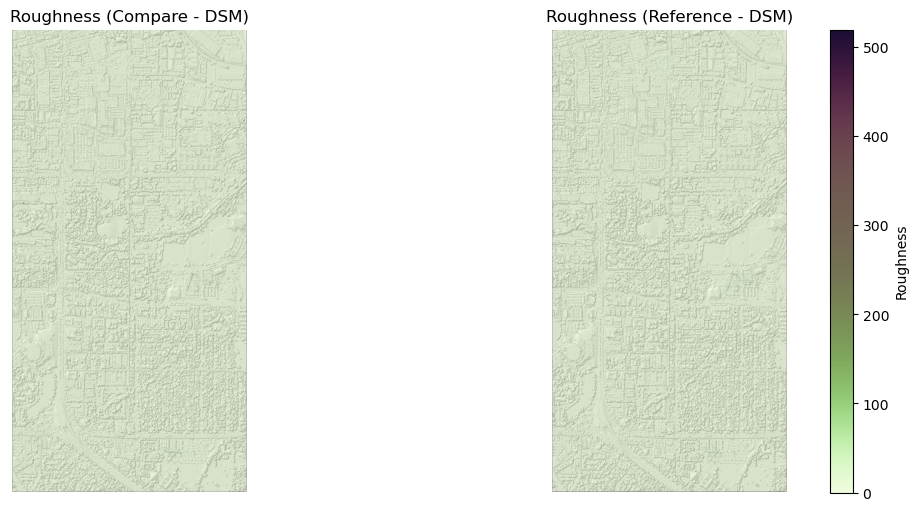

In [20]:
fig = roughness_dsm.plot_pair(
        overlay = compare_hillshade_dsm,
        overlay_alpha = 0.3,
        titles=("Roughness (Compare - DSM)", "Roughness (Reference - DSM)"),
        base_cmap=cmaps.tokyo_r,
        legend = "Roughness",
        overlay_cmap=cmaps.neutral,
    )

<h2><a id="differencing"></a>Differencing</h2>

Topographic differencing, or raster subtraction, is the cell-by-cell subtraction of two aligned DEMs to produce a DEM of Difference (DoD) that quantifies vertical change[cite: 66, 67].

In [16]:
out_folder_diff = folder+"differencing/"
os.makedirs(out_folder_diff, exist_ok=True)

topodiff = TopoDifferencer(out_folder_diff)

In [17]:
if change_dtms is not None:
    dtm_diff = topodiff.save_difference_raster(change_dtms, 'dtm_diff')

if change_dsms is not None:
    dsm_diff = topodiff.save_difference_raster(change_dsms, 'dsm_diff')


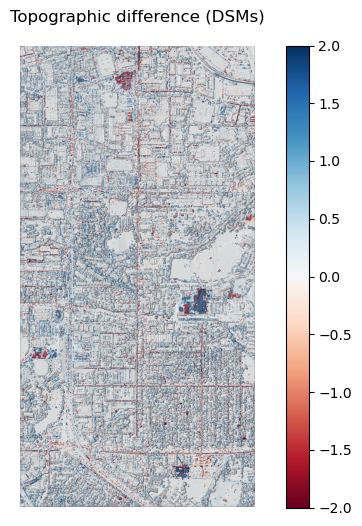

In [18]:
fig = topodiff.plot_difference(
        diff_path = dsm_diff.path,
        overlay = compare_hillshade_dsm,
        cmap="RdBu",
        vmin = -2,
        vmax = 2,
        center_zero = True,
        overlay_alpha = 0.4,
        title = "Topographic difference (DSMs)",
)

<h2><a id="error-analysis"></a>Error Analysis</h2>

<h3><a id="define-stable-areas"></a>Define stable areas</h3>

A key part of this workflow is the use of **stable areas**—regions where no topographic change is expected—to characterize the error between the two surveys. This interactive map allows you to manually draw polygons over areas you consider stable (e.g., roads, bedrock outcrops, undisturbed ground). [cite_start]The elevation differences within these areas are then used to model the uncertainty[cite: 220, 314, 315].

In [19]:
## Point classification
    # boulder_aoi1 : construction, pit; area: 15127 m²
aoi1 = "/Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Data analysis/Error/Manuscript/Results/point_classification/boulder_aoi1.shp"
    # boulder_aoi2 : construction, pit; area: 13176 m²
aoi2 = "/Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Data analysis/Error/Manuscript/Results/point_classification/boulder_aoi2.shp"
    # boulder_aoi_circular_10k
aoi_circle = "/Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Data analysis/Error/Manuscript/Results/point_classification/boulder_aoi_circular_10k.shp"
    # boulder_aoi_25x400rectangle_10k
aoi_rectangle = "/Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Data analysis/Error/Manuscript/Results/point_classification/boulder_aoi_25x1000rectangle_25k.shp"

## Geometric distortion
## Topo correlation
## Flightline error
## Geoid error
## Ortho/Ellipsoid error


In [20]:
out_folder_poly = folder+"polygons/"
os.makedirs(out_folder_poly, exist_ok=True)


interactor = TopoMapInteractor(
    topo_diff_path=dtm_diff.path,
    hillshade_path=compare_hillshade_dtm.path,
    output_dir=out_folder_poly,
    overlay_dpi=600,
    overlay_vmin=-2,
    overlay_vmax=2,
)

interactor.map

Map(center=[40.00982182127451, -105.25360891306518], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [21]:
interactor.load_unstable_polygons(aoi1)
interactor.load_unstable_polygons(aoi2)
interactor.load_unstable_polygons(aoi_circle)
interactor.load_unstable_polygons(aoi_rectangle)

interactor.map

Map(center=[40.00982182127451, -105.25360891306518], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [50]:
interactor.stable_geoms

[<POLYGON ((-105.245 40.023, -105.245 39.997, -105.262 39.997, -105.262 40.02...>]

<h3><a id="descriptive-stats"></a>Descriptive Statistics</h3>

In [77]:
stable_polys, _ = interactor.get_geodataframes()

# one combined mask
rasterizer_stable = StableAreaRasterizer(interactor.topo_diff.path, stable_polys, nodata=-9999)
analyzer_stable = StableAreaAnalyzer(rasterizer_stable)

# Combined-area stats
df_all_stable_polys = analyzer_stable.stats_all(folder+"polygons/combined_stable.tif")

# Per-area stats
df_each_stable_poly = analyzer_stable.stats_each(folder+"polygons/each_stable/")


In [78]:
df_all_stable_polys

,mean,median,mode,std,variance,min,max,skewness,kurtosis,0.5_percentile,99.5_percentile
all_areas,0.037892,0.007935,0.01001,0.300955,0.090574,-5.958862,20.045288,17.539091,532.874329,-0.317061,1.513428


In [79]:
df_each_stable_poly

,mean,median,mode,std,variance,min,max,skewness,kurtosis,0.5_percentile,99.5_percentile
area_id,,,,,,,,,,,
0,0.037892,0.007935,0.01001,0.300955,0.090574,-5.958862,20.045288,17.539091,532.874329,-0.317061,1.513428


<h3><a id="estimate-error"></a>Estimate systematic error</h3>

In [158]:
vert_diff_path_dtm = folder+"polygons/combined_stable.tif"
output_path = folder+"polygons/combined_stable_bias_removed.tif"

unit = "m"
dem_resolution = 1.0

In [159]:
#Load raster data
raster_data_handler_dtm=RasterDataHandler(vert_diff_path_dtm, unit, dem_resolution)
raster_data_handler_dtm.load_raster()

vert_diff_array_dtm = raster_data_handler_dtm.data_array

#With the assumption that the distribution of vertical differences should be centered on zero given a large enough area, let's take the median as the measure of vertical bias.
vertical_bias = np.median(vert_diff_array_dtm)

#Get a measure of the uncertainty in the median value by bootstrap resampling (10% of the total observations, 1000x)
stats_dtm = StatisticalAnalysis(raster_data_handler_dtm)
median_uncertainty = stats_dtm.bootstrap_uncertainty_subsample()

#Subtract the vertical bias from the original raster and save as a file
raster_data_handler_dtm.subtract_value_from_raster(output_path, vertical_bias)

#Create new raster handling instance for modified raster, load raster and create data array
raster2_data_handler=RasterDataHandler(output_path, unit, dem_resolution)
raster2_data_handler.load_raster()


In [160]:
vertical_bias

np.float64(0.0079345703125)

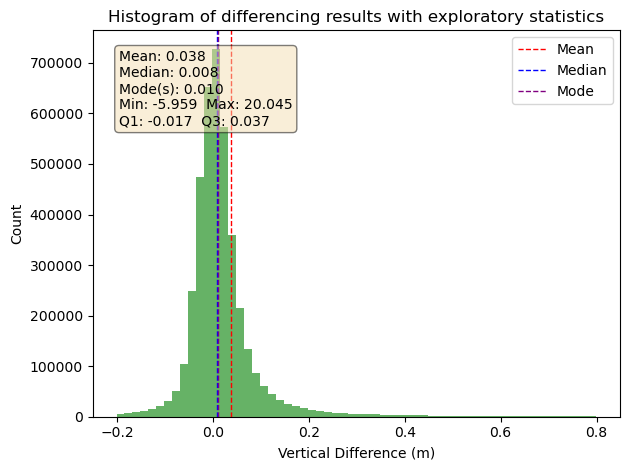

In [161]:
fig = stats_dtm.plot_data_stats()

<h3><a id="Variography"></a>Variography</h3>

This section uses the stable areas defined above to perform the geostatistical analysis. [cite_start]An experimental variogram is calculated from the DoD values within the stable areas, and then a mathematical model (nested spherical) is fitted to it[cite: 112, 121, 122]. [cite_start]This model captures the spatial correlation of the error, which is then used to propagate uncertainty across the entire study area[cite: 113, 127].

In [162]:
#Create variogram analysis instance based on modified raster
V = VariogramAnalysis(raster2_data_handler)

#Calculate a mean variogram with 75 bins from variograms made over 10 runs
V.calculate_mean_variogram_numba(area_side = 250, samples_per_area = 400, max_samples = 1000000000, bin_width = 30, max_n_bins = 3000, n_runs = 30, max_lag_multiplier = 0.5)

/Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Code/error_analysis/variography_uncertainty_3.py:620: RuntimeWarning: Mean of empty slice
  ----------
/opt/anaconda3/envs/sage-gage-exercise/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Code/error_analysis/variography_uncertainty_3.py:624: RuntimeWarning: Mean of empty slice
  structural = params[:-1]
/opt/anaconda3/envs/sage-gage-exercise/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [163]:
BOUNDS = None

V.fit_best_spherical_model(sigma_type='std', bounds=BOUNDS, seed=SEED)

In [140]:
n = V.best_model_config['components']
nug = V.best_model_config['nugget']
lb = [0]*n + [1]*n + ([0] if nug else [])
ub = [np.inf]*n + [np.max(V.lags)]*n + ([np.inf] if nug else [])
bounds_cv = (lb, ub)

V.cv_mean_error_best_aic = V.cross_validate_variogram(
    V.best_model_func, V.best_params, bounds_cv, k=5, seed=SEED
)

In [164]:
V.cv_mean_error_best_aic

{'rmse': np.float64(0.006401909408188083),
 'mae': np.float64(0.005582411408633616),
 'me': np.float64(0.0009281614343227302),
 'mse': np.float64(4.138341393623297e-05)}

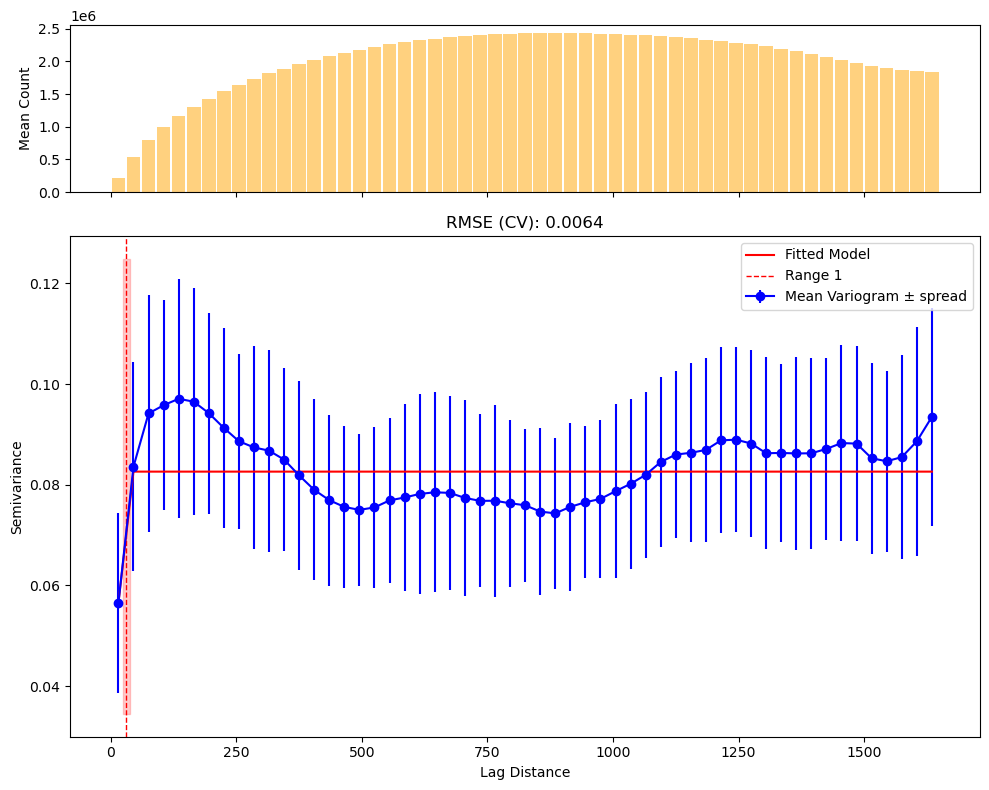

In [165]:
fig = V.plot_best_spherical_model()

<h3><a id="Total mean error"></a>Total mean error</h3>

In [63]:
interactor.map

Map(bottom=3175853.0, center=[40.00982182127451, -105.25360891306518], controls=(ZoomControl(options=['positio…

In [142]:
interactor.unstable_geoms

[<POLYGON ((-105.261 40.006, -105.26 40.006, -105.26 40.006, -105.26 40.006, ...>,
 <POLYGON ((-105.255 40.021, -105.254 40.021, -105.254 40.021, -105.254 40.02...>,
 <POLYGON ((-105.25 40.009, -105.249 40.009, -105.249 40.009, -105.249 40.009...>,
 <POLYGON ((-105.261 40.012, -105.261 40.012, -105.25 40.012, -105.25 40.012,...>]

In [143]:
_, unstable_polys = interactor.get_geodataframes()

In [146]:
uncertainties_per_feature_of_interest = []
for i, poly in enumerate(unstable_polys['geometry']):
    uncertainty_temp = RegionalUncertaintyEstimator(raster2_data_handler, V, area_of_interest=poly)
    uncertainty_temp.calc_mean_uncertainty(n_pairs=25_000, seed=SEED, sigma_func=None)
    uncertainties_per_feature_of_interest.append(uncertainty_temp)

In [147]:
uncertainties_per_feature_of_interest[0].print_results()

Variogram Analysis Results:
Ranges: [28.9140535]; min: [23.1369811]; max: [38.53497024]
Sills: [0.07764894]; min: [0.07750549]; max: [0.08046479]
Best Model Parameters: [ 0.07764894 28.9140535 ]

Uncertainty Results for Polygon of interest:
Polygon Area (m²): 15114.65
Mean Random Uncorrelated Uncertainty: 0.0001
Mean Random Correlated 1: 0.0519; min: 0.0415; max: 0.0652
Total Mean Correlated Uncertainty (Polygon): 0.0519; min: 0.0415; max: 0.0652
Total Mean Uncertainty (Polygon): 0.0519; min: 0.0415; max: 0.0652

Uncertainty Results for Raster:
Coarse raster Area (m²): 4206219.00
Mean Random Correlated 1 (Raster): 0.0023; min: 0.0017; max: 0.0034
Total Mean Correlated Uncertainty (Raster): 0.0023; min: 0.0017; max: 0.0034
Total Mean Uncertainty (Raster): 0.0023; min: 0.0017; max: 0.0034


In [148]:
uncertainties_per_feature_of_interest[1].print_results()

Variogram Analysis Results:
Ranges: [28.9140535]; min: [23.1369811]; max: [38.53497024]
Sills: [0.07764894]; min: [0.07750549]; max: [0.08046479]
Best Model Parameters: [ 0.07764894 28.9140535 ]

Uncertainty Results for Polygon of interest:
Polygon Area (m²): 13176.10
Mean Random Uncorrelated Uncertainty: 0.0001
Mean Random Correlated 1: 0.0533; min: 0.0421; max: 0.0677
Total Mean Correlated Uncertainty (Polygon): 0.0533; min: 0.0421; max: 0.0677
Total Mean Uncertainty (Polygon): 0.0533; min: 0.0421; max: 0.0677

Uncertainty Results for Raster:
Coarse raster Area (m²): 4206219.00
Mean Random Correlated 1 (Raster): 0.0023; min: 0.0017; max: 0.0034
Total Mean Correlated Uncertainty (Raster): 0.0023; min: 0.0017; max: 0.0034
Total Mean Uncertainty (Raster): 0.0023; min: 0.0017; max: 0.0034


In [149]:
uncertainties_per_feature_of_interest[2].print_results()

Variogram Analysis Results:
Ranges: [28.9140535]; min: [23.1369811]; max: [38.53497024]
Sills: [0.07764894]; min: [0.07750549]; max: [0.08046479]
Best Model Parameters: [ 0.07764894 28.9140535 ]

Uncertainty Results for Polygon of interest:
Polygon Area (m²): 24995.25
Mean Random Uncorrelated Uncertainty: 0.0001
Mean Random Correlated 1: 0.0406; min: 0.0324; max: 0.0516
Total Mean Correlated Uncertainty (Polygon): 0.0406; min: 0.0324; max: 0.0516
Total Mean Uncertainty (Polygon): 0.0406; min: 0.0324; max: 0.0516

Uncertainty Results for Raster:
Coarse raster Area (m²): 4206219.00
Mean Random Correlated 1 (Raster): 0.0023; min: 0.0017; max: 0.0034
Total Mean Correlated Uncertainty (Raster): 0.0023; min: 0.0017; max: 0.0034
Total Mean Uncertainty (Raster): 0.0023; min: 0.0017; max: 0.0034


In [150]:
uncertainties_per_feature_of_interest[3].print_results()

Variogram Analysis Results:
Ranges: [28.9140535]; min: [23.1369811]; max: [38.53497024]
Sills: [0.07764894]; min: [0.07750549]; max: [0.08046479]
Best Model Parameters: [ 0.07764894 28.9140535 ]

Uncertainty Results for Polygon of interest:
Polygon Area (m²): 25000.00
Mean Random Uncorrelated Uncertainty: 0.0001
Mean Random Correlated 1: 0.0334; min: 0.0271; max: 0.0406
Total Mean Correlated Uncertainty (Polygon): 0.0334; min: 0.0271; max: 0.0406
Total Mean Uncertainty (Polygon): 0.0334; min: 0.0271; max: 0.0406

Uncertainty Results for Raster:
Coarse raster Area (m²): 4206219.00
Mean Random Correlated 1 (Raster): 0.0023; min: 0.0017; max: 0.0034
Total Mean Correlated Uncertainty (Raster): 0.0023; min: 0.0017; max: 0.0034
Total Mean Uncertainty (Raster): 0.0023; min: 0.0017; max: 0.0034


In [125]:
import time

uncertainty_1 = RegionalUncertaintyEstimator(raster2_data_handler, V, area_of_interest=unstable_polys['geometry'][1])

# Monte Carlo correlated term (seeded)
t0 = time.perf_counter()
sigA_mc = uncertainty_1.estimate_monte_carlo(uncertainty_1.gamma_func_total, n_pairs=10_000, seed=SEED)
t_mc = time.perf_counter() - t0
print(f"Monte Carlo method time: {t_mc:.4f} seconds")

# FFT (no seed needed)
t0 = time.perf_counter()
sigA_fft = uncertainty_1.estimate_fft(uncertainty_1.gamma_func_total, grid_points=100)
t_fft = time.perf_counter() - t0
print(f"FFT method time: {t_fft:.4f} seconds")

# Brute force (no seed needed)
t0 = time.perf_counter()
sigA_brute = uncertainty_1.estimate_brute_force(uncertainty_1.gamma_func_total, grid_points=100)
t_brute = time.perf_counter() - t0
print(f"Brute force method time: {t_brute:.4f} seconds")

# Hugonnet shortcut (seeded)
t0 = time.perf_counter()
sigA_hug = uncertainty_1.estimate_hugonnet(uncertainty_1.gamma_func_total, k=100, seed=SEED)
t_hug = time.perf_counter() - t0
print(f"Hugonnet shortcut method time: {t_hug:.4f} seconds")

# End-to-end summary (Monte Carlo internal seeding)
t0 = time.perf_counter()
uncertainty_1.calc_mean_uncertainty(n_pairs=10_000, seed=SEED)
t_summary = time.perf_counter() - t0
print(f"End-to-end summary computation time: {t_summary:.4f} seconds")

uncertainty_1.print_results()

Monte Carlo method time: 0.5260 seconds
FFT method time: 0.2163 seconds
Brute force method time: 279.0204 seconds
Hugonnet shortcut method time: 81.1035 seconds
End-to-end summary computation time: 3.6065 seconds
Variogram Analysis Results:
Ranges: [31.429843]; min: [27.32728121]; max: [37.85081535]
Sills: [0.08883552]; min: [0.08877434]; max: [0.09123823]
Best Model Parameters: [ 0.08883552 31.429843  ]

Uncertainty Results for Polygon of interest:
Polygon Area (m²): 24995.25
Mean Random Uncorrelated Uncertainty: 0.0001
Mean Random Correlated 1: 0.0461; min: 0.0396; max: 0.0538
Total Mean Correlated Uncertainty (Polygon): 0.0461; min: 0.0396; max: 0.0538
Total Mean Uncertainty (Polygon): 0.0461; min: 0.0396; max: 0.0538

Uncertainty Results for Raster:
Coarse raster Area (m²): 4206219.00
Mean Random Correlated 1 (Raster): 0.0028; min: 0.0025; max: 0.0036
Total Mean Correlated Uncertainty (Raster): 0.0028; min: 0.0025; max: 0.0036
Total Mean Uncertainty (Raster): 0.0028; min: 0.0025; m

In [145]:
print(f"Monte Carlo: {sigA_mc}")
print(f"FFT: {sigA_fft}")
print(f"Brute Force: {sigA_brute}")
print(f"Hugonnet: {sigA_hug}")

Monte Carlo: 0.04503021829372272
FFT: 0.04474465220652576
Brute Force: 0.04474465220652577
Hugonnet: 0.04459256090053961
